The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


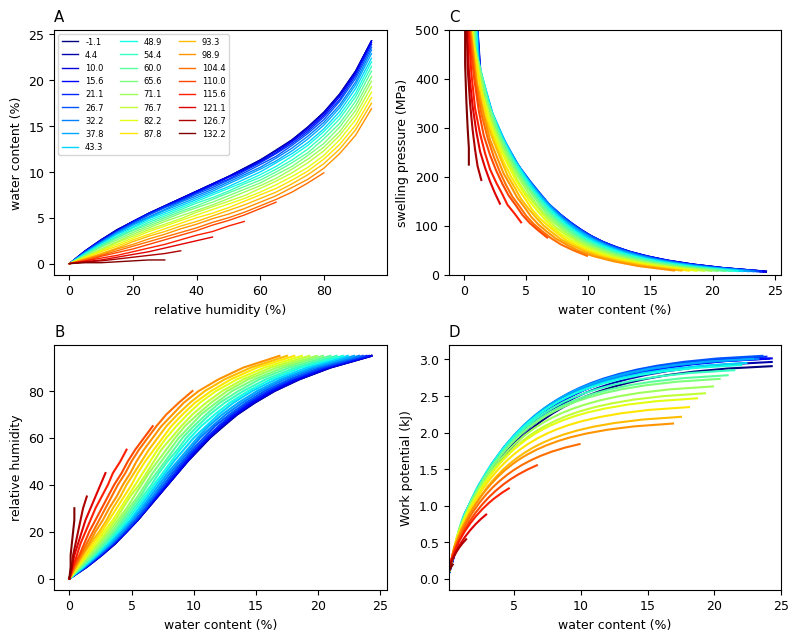

In [7]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas
from matplotlib.font_manager import FontProperties

R = 8.31446261815324 #gas constant
kelvin = 273.15
water_mol_vol = 18.
data_url = "https://github.com/yoshi-CERMAV/wood-sorption-data/raw/main/wood_sorption_data.pkl.bz2"
df = pandas.read_pickle(data_url) 
df1 = df.copy();

#obtaining swelling pressure from eq1
humidity = df.index+.1 #to avoid log(0)

for a in df.columns:
    df1[a]= -(273.15+a)*R/water_mol_vol*np.log(humidity/100.)

# numerical integration to obtain work 
from scipy.interpolate import interp1d
from scipy.integrate import quad
df2 = df.copy();
j = 0
for a in df.columns:
    I = [0] * df[a].size
    t = interp1d(y = -(kelvin+a)*R/water_mol_vol*np.log(humidity/100.), x = df[a])
    for i in range (0, df[a].values.size):
        df2[a].values[i] = quad(t, 0, df[a].values[i], full_output=1)[0]/1000.
    j+=1

#just plotting
colors =  pl.cm.jet(np.linspace(0,1,25))
cm = 1/2.54
font = FontProperties()
font.set_family('arial')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20*cm, 16*cm), constrained_layout=True)
plt.rcParams.update({'font.size': 9})
ax = df.plot(color=colors,  linewidth=1, ax=axes[0, 0])
ax.set_title('A',loc='left')
ax.set_ylabel("water content (%)", fontsize=9)
ax.legend(ncol=3, fontsize=9, prop={'size': 6})#, bbox_to_anchor=(0.1, .9))
ax2=axes[1,0]
ax2.set_title('B', loc='left')
ax2.set_xlabel("water content (%)", size=9)
ax2.set_ylabel("relative humidity")
ax3= axes[0,1]
ax3.set_title('C',loc='left')
ax3.set_xlabel("water content (%)")
ax3.set_ylabel("swelling pressure (MPa)")
ax4= axes[1,1]
ax4.set_title('D',loc='left')
ax4.set_xlabel("water content (%)")
ax4.set_ylabel("Work potential (kJ)")

def plot_yx(df, ax):
    i = 0
    for a in df.columns:
        ax.plot(df[a], df.index, color = colors[i])
        i+=1
def plot_yx1(df,df1, ax):
    i = 0
    for a in df.columns:
        ax.plot(df[a], df1[a], color = colors[i])
        i+=1

plot_yx(df,ax2)
plot_yx1(df, df1, ax3)
ax3.set_ylim(0,500)
plot_yx1(df, df2, ax4)
fig.savefig("test.pdf")

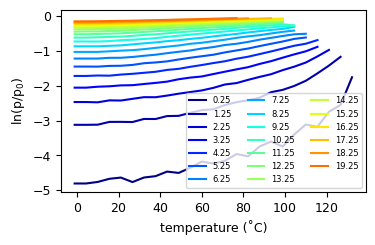

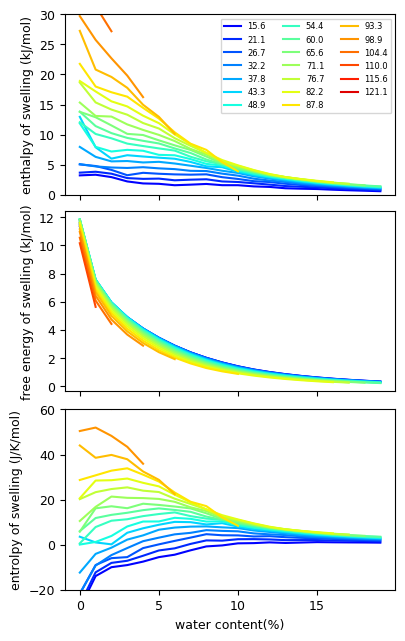

In [9]:
import scipy.interpolate as interp
from scipy.interpolate import CubicSpline
import numpy as np

df = pandas.read_pickle("wood_sorption_data.pkl.bz2") 

#make list of equilibrium relative humidity as function of moisture content at each temperature 
data= np.zeros((20,25))
for j in range (0, 20):
    for i in range (0,25): #among the 25 temperatures in the data
        ip = CubicSpline(df.index, df.iloc[:,i].fillna(0).values-j-0.25) # j+0.25 is the moisture content
        t = ip.roots(extrapolate=False)
        if(t.size):
            data[j,i]=t[0]
        else:
            data[j,i]=np.nan
            
import numpy.polynomial.polynomial as poly
#colors =  pl.cm.jet(np.linspace(0,1,20))

df_new =pandas.DataFrame(data, columns = df.columns) 
df_new.index.title="water content (%)"
df_new.index=np.linspace(0.25,19.25,20) #equillibrium humidity as function of moisture content for each temperature
df_new_tr = np.log(df_new.T/100.) #transposition: log(humidity) as function of temperature for each moisture content
                
R = 8.31446261815324 #gas constant J/K/mol
T0 = 273.15 # K at 0˚C
ene = np.zeros((20,20)) #enthalpy
ent = np.zeros((20,20)) #entropy
fre = np.zeros((20,20)) #gibbs free energy

for i in range (0,20):
    mask = [~np.isnan(df_new_tr.iloc[:,i].values)]
#plt.plot(df_new1.index[mask], df_new1[1].values[mask])
    x = df_new_tr.index[tuple(mask)].copy()
    y = df_new_tr.iloc[:,i].values[tuple(mask)].copy()
    rh= np.zeros(20)
    enth= np.zeros(20)
    gibbs = np.zeros(20)
    entro = np.zeros(20)
    for k in range(0,20):
        xs = x[k:k+7]
        ys = y[k:k+7]
        if(xs.size>6):
            T = xs[3]+T0
            p_fitted = poly.Polynomial.fit(xs,ys, deg=1)
            enth[k] = p_fitted.deriv()(xs[3])*T*R
            gibbs[k] = -p_fitted(xs[3])*R
            entro[k] = enth[k]-gibbs[k]
            enth[k] *= T
            gibbs[k] *= T
 #           derx[k] = xs[3]
        else:
            enth[k]=np.nan
  #          derx[k]=np.nan
            entro[k]=np.nan
            gibbs[k]=np.nan
    ene[i]=enth
    fre[i]=gibbs
    ent[i]=entro
df_ene = pandas.DataFrame(ene*1e-3)
df_fre = pandas.DataFrame(fre*1e-3)
df_ent = pandas.DataFrame(ent)

aa=df.columns
df_ene.columns = aa[3:23]
df_fre.columns = aa[3:23]
df_ent.columns = aa[3:23]

colors =  pl.cm.jet(np.linspace(0,1,25))
ax=df_new_tr.plot(color=colors, xlabel = 'temperature (˚C)',ylabel = 'ln(p/p$_0$)',figsize=(10*cm,6*cm))
ax.legend(ncol=3, fontsize=9, prop={'size': 6})
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10*cm, 16*cm), constrained_layout=True, sharex=True, )
axes[0].set_ylim(0,30)
axes[2].set_ylim(-20,60)
df_ene.plot(ax = axes[0],color=colors[3:23], ylabel = 'enthalpy of swelling (kJ/mol)')
axes[0].legend(ncol=3, fontsize=9, prop={'size': 6})
df_fre.plot(ax = axes[1], color=colors[3:23], legend=None, ylabel = 'free energy of swelling (kJ/mol)')
df_ent.plot(ax = axes[2],color=colors[3:23],legend=None, ylabel = 'entrolpy of swelling (J/K/mol)',xlabel = 'water content(%)')
plt.savefig("GHS.pdf")